In [1]:
import numpy as np
import scipy.linalg as linalg
from helper import hermitian, awgn, draw

In [2]:
doa = np.array( [ 20.0, 60.0 ] ) / 180 * np.pi # direction of arrival
N = 200 # number of samples
w = hermitian(np.array( [ 0.2, 0.7 ] )) # frequency
M = 10 # number of array elem
P = len(w) # number of signal
lam = 150.0 # wavelength
d = lam / 2 # elem spacing
snr = 20.0 # signal to noise ratio
# Assignment Matrix
D = np.zeros( (P, M), dtype=complex )
for k in range(P):
    D[k,:] = np.exp( -1j * 2 * np.pi * d * np.sin(doa[k]) / lam * np.array(range(M)) )
D = hermitian(D)
xx = np.zeros((P,N), dtype=complex)
for i, f in enumerate(w):
    xx[i,:] = np.array(2*np.exp( 1j * (f * (np.array(range(N)) + 1)))) # Simulate Signal
x = D @ xx
print(x.shape)
x += awgn(x,snr) # Insert Gaussian noise

(10, 200)


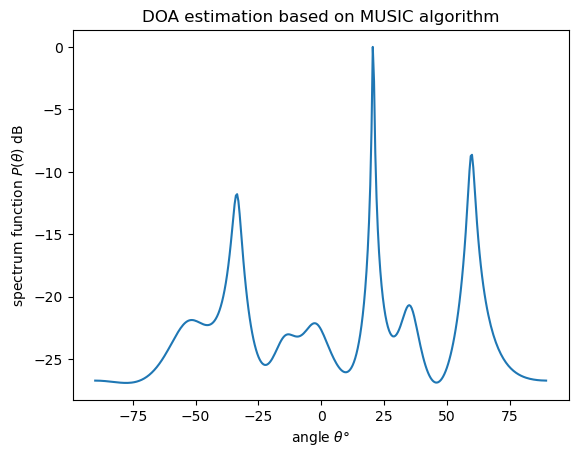

In [3]:
def MUSIC():
    R = x @ hermitian(x) #covariance matrix
    eigenValues, eigenVectors = linalg.eig(R) # eigenvalues/vector of R
    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    NN = eigenVectors[:,M-P:] # estimate noise subspace
    theta = np.arange(-90,90,0.5, dtype=float) # peak search
    Pmusic = np.zeros((len(theta)))
    for ii in range(len(theta)):
        SS = np.zeros((1, M), dtype=complex)
        for jj in range(M):
            SS[0, jj] = np.exp( -1j * 2.0 * jj * np.pi * d * np.sin(theta[ii]/180 * np.pi) / lam )
        PP = SS @ NN @ hermitian(NN) @ hermitian(SS)
        Pmusic[ii] = np.abs(1/PP)
    Pmusic = 10 * np.log10(Pmusic/np.max(Pmusic)) # Spatial spectrum function
    draw( theta, Pmusic, r'angle $\theta \degree$', r'spectrum function $P(\theta)$ dB', 'DOA estimation based on MUSIC algorithm' )

MUSIC()

(1, 2) (2, 400)


c:\Users\alck2\anaconda3\envs\math4999\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


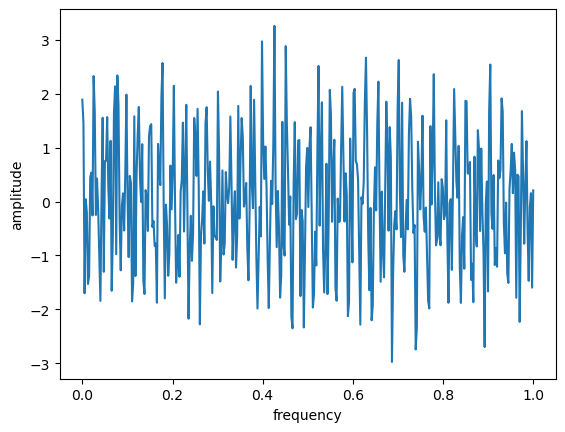

In [4]:
frequencies = [ 0.1, 0.8 ]
N = 400 # number of samples
w = hermitian(np.array(frequencies)) # frequency
P = len(w) # number of signal
lam = 150.0 # wavelength
snr = 30.0 # % signal to noise ratio
# Assignment Matrix
D = np.zeros( (P, N), dtype=complex )
a = np.linspace(0, 1, N)
for k in range(P):
    D[k] = np.exp( -1j * 2 * np.pi * d * a / lam )
D = hermitian(D)
D = np.ones((1,P))
xx = np.zeros((P,N), dtype=complex)
for i, f in enumerate(w):
    xx[i,:] = np.array(np.exp( 1j * 2 * np.pi * np.array(range(N)) * np.sin(f)  )) # Simulate Signal
print(D.shape, xx.shape)
x = D @ xx
x += awgn(x,snr) # Insert Gaussian noise
draw(np.linspace(0,1,N),x.reshape(N,-1),"frequency","amplitude","")

[6.93132446 5.01981051 2.3630307  1.70304829 1.36861029 0.73935028]
0.7092731829573935


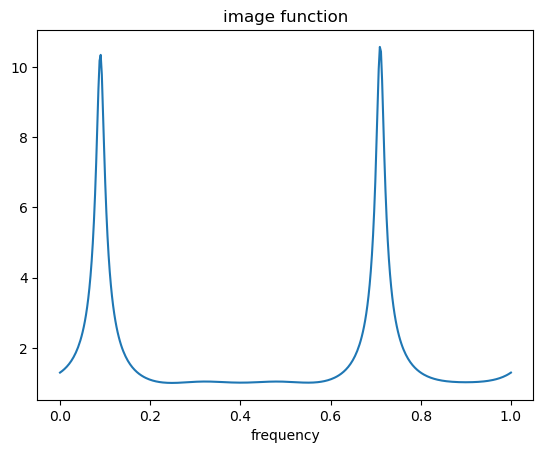

In [5]:
# s : number of freq
def MUSIC_LSE(z,s,L):
    phi_L = lambda omega : np.array([np.exp(-2 * np.pi * 1j * omega * k ) for k in range(L+1) ])
    H_epsilon = np.block([
        [ z[l+j] for j in range(M-L+1) ] for l in range(L+1)
    ])
    U,S,V = np.linalg.svd(H_epsilon, full_matrices=True)
    print(S)
    U2 = U[:,s:]
    support = np.linspace(0,1,N)
    J_func = lambda omega : np.linalg.norm(phi_L(omega), 2) / np.linalg.norm(hermitian(U2) @ phi_L(omega), 2)
    J = np.array([ J_func(omega) for omega in support ])
    draw(1-support, J, "frequency", "", "image function")
    print(1-support[np.argmax(J)])
MUSIC_LSE(x.T, P, M//2)